In [210]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import sklearn
import separator
sep = separator.SeparateText()

# print versions of libraries
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"sklearn version: {sklearn.__version__}")


numpy version: 1.24.4
pandas version: 2.1.3
sklearn version: 1.3.2


In [211]:
# import mnist dataset
# Sklearn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

C:\Users\lazni\PycharmProjects\Training\venv\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [212]:
# The dict keys you see above can be used for various purposes. For example, in the row below you see that you can use "data" and "target" to access features and labels of the dataset.
X, y = np.array(mnist["data"]), np.array(mnist["target"])

print("Shape of all features: ", X.shape)
print(f"Each feature is an image 28x28: {28**2=}")  # number of pixels each image has (28x28)
print("Contents of first index of features: ", X[0])
print("Shape of labels: ", y.shape)
print("Content of first index of labels: ", y[0])  # first number is labeled as 5

Shape of all features:  (70000, 784)
Each feature is an image 28x28: 28**2=784
Contents of first index of features:  [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
  18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. 

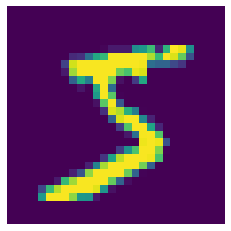

In [213]:
# Take first element of the features
some_digit = np.array(X)[0]

# Reshape the first element from 1D array to 2D array
some_digit_image = some_digit.reshape(28, 28)

# Plot the image
plt.imshow(some_digit_image)
plt.axis("off")
plt.show()

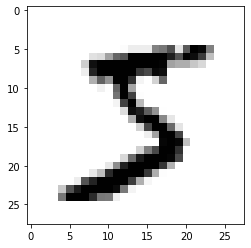

In [214]:
# Convert to black and white colors.
plt.imshow(some_digit_image, cmap="binary")
plt.show()

In [215]:
# Check label of the first image. It is number 5 just as we see on the image.
y[0]

'5'

In [216]:
# Labels are stored as strings in this dataset so let's change them to int.
print(type(y[0]))

# Convert to int
y = y.astype(np.uint8)
print(type(y[0]))

<class 'str'>
<class 'numpy.uint8'>


In [283]:
# Custom function of author of the book to plot multiple images in a grid. If you are interested you can check out the source code below, otherwise it is not important to understand it to continue in this notebook.
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

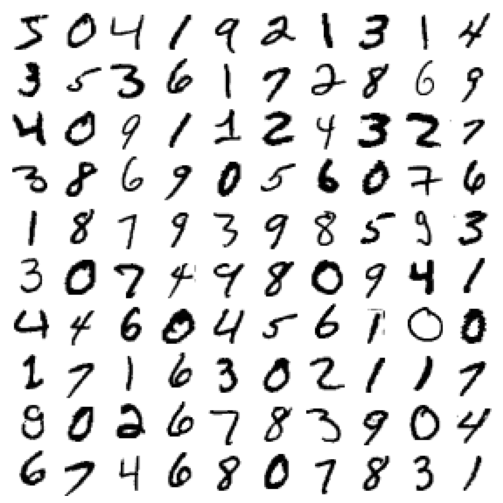

In [218]:
# Display a bunch of images in a grid.
plt.figure(figsize=(9, 9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [219]:
# Mnist dataset is already shuffled (cross-validation folds will be similar) and already split into training and test set (first 60,000 are training, remaining 10,000 are test set). 

X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

# BINARY CLASSIFIER


In [220]:
# Let's train a classifier to only predict whether number is 5 or not in this dataset. Meaning we will have only two classes: 5 and not 5.

# This numpy syntax applies to each item in array. It will return True for all 5s, and False for all other digits.
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [221]:
# See that the places where we have 5 is True, and where we don't have 5 is False.
print(y_train_5)
print(y_train)

[ True False False ...  True False False]
[5 0 4 ... 5 6 8]


In [222]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

# PERFORMANCE MEASURES

#### CROSS-VALIDATION

In [223]:
# Build custom cross validation (can be useful if you want more control over it)
# Occasionally you will need more control over the cross-validation process than what Scikit-Learn provides off-the-shelf. In these cases, you can implement cross-validation yourself. The following code does roughly the same thing as Scikit-Learn’s cross_val_score() function, and prints the same result:

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# StratifiedKFold - This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.
# In my own words, you can get out of this object with these parameters 3 splits. And each spilt will have 2 arrays. First array will be the indexes of the training set, and second array will be the indexes of the test set. The indexes are shuffled and stratified (meaning that each split will have same percentage of each class as the whole dataset).
number_of_splits = 3
stratified_k_folds = StratifiedKFold(
    n_splits=number_of_splits,
    shuffle=True,
    random_state=42,
)

#------------------------------------------------------------------------------------------------
# Just my own extra data to explain stuff:
print(
    "Visualisation of stratified k folds. These are only indexes which you will later use as a filter to get actual data from dataset:\n")
for train, test in stratified_k_folds.split(X_train, y_train_5):
    # In the printed data you will see that the number of data is still 60_000, but the length of train and test set will be the result of 60_000 / n_splits. In this case of 3 splits 40 vs 20 thousand.
    print(train, f"Shape: {train.shape}")
    print(test, f"Shape: {test.shape}")
    print("-" * 50)

#------------------------------------------------------------------------------------------------

print("\nActual custom implementation of cross validation:\n")
scores = []
for train_index, test_index in stratified_k_folds.split(X_train, y_train_5):
    # Clone the classifier to have the exact same model as before. Author of the book does not explain why.
    clone_classifier = clone(sgd_classifier)

    # Get the actual training and test set values from the dataset using the indexes from the stratified k folds.
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    # Train the model, predict and compute accuracy.
    clone_classifier.fit(X_train_folds, y_train_folds)
    y_pred = clone_classifier.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    result = n_correct / len(y_pred)
    scores.append(result)
    print(f"Accuracy: {result}")

print(f"Mean of all accuracy {number_of_splits} scores: {np.array(scores).mean()}")

# Still remember that the results you see here, are made on classification whether number is 5 or not.

Visualisation of stratified k folds. These are only indexes which you will later use as a filter to get actual data from dataset:

[    1     3     4 ... 59994 59996 59998] Shape: (40000,)
[    0     2     6 ... 59995 59997 59999] Shape: (20000,)
--------------------------------------------------
[    0     2     3 ... 59997 59998 59999] Shape: (40000,)
[    1    10    11 ... 59988 59989 59991] Shape: (20000,)
--------------------------------------------------
[    0     1     2 ... 59995 59997 59999] Shape: (40000,)
[    3     4     5 ... 59994 59996 59998] Shape: (20000,)
--------------------------------------------------

Actual custom implementation of cross validation:
Accuracy: 0.9669
Accuracy: 0.91625
Accuracy: 0.96785
Mean of all accuracy 3 scores: 0.9503333333333334


In [224]:
# we can use the build-in function to do the same cross-validation as above
from sklearn.model_selection import cross_val_score

results = cross_val_score(
    estimator=sgd_classifier,
    X=X_train,
    y=y_train_5,
    verbose=2,
    cv=3,
    scoring="accuracy",
)
results

[CV] END .................................................... total time=   6.5s
[CV] END .................................................... total time=   6.0s
[CV] END .................................................... total time=   4.7s


array([0.95035, 0.96035, 0.9604 ])

In [225]:
f"Accuracy from build-in sklearn function: {results.mean()}"

'Accuracy from build-in sklearn function: 0.9570333333333334'

In [226]:
# Let's pretend that we create a custom estimator that always predicts that the number is not 5, to see that accuracy is not always the best metric to use.

from sklearn.base import BaseEstimator


class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        # Create a matrix of shape X, 1. Complete array with False values.
        return np.zeros((len(X), 1), dtype=bool)

In [227]:
np.zeros((len(X), 1), dtype=bool)

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [228]:
# Our custom estimator will always predict that the number is not 5. But since we have 10 numbers, it will be right 90% of the time. So accuracy is not always the best metric to use.
never_5_clf = Never5Classifier()
print("Accuracy scores: ",
      cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy"))

Accuracy scores:  [0.91125 0.90855 0.90915]


#### CONFUSION MATRIX
If you are interested, there is also dedicated notebook for confusion matrix in this repository.

In [229]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix.
# To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets. You could make predictions on the test set, but let’s keep it untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). Instead, you can use the cross_val_predict() function:
y_train_predictions = cross_val_predict(
    estimator=sgd_classifier,
    X=X_train,
    y=y_train_5,
    cv=3
)
# Just like cross_val_score() function, cross_val_predict() performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).
# Little more explanation of cross_val_predict() function by github-copilot:
# Question by TL: Lets say you have linear regression model, and you are trying to predict a number. You have 1000 train features. You tell the method to use 3 fold split. Does it mean that when the cross_val_predict is executed, the resulting prediction is an average of 3 numbers or not?
# Answered by copilot: No, the resulting prediction from cross_val_predict is not an average of 3 numbers. When you specify a 3-fold cross-validation, the function splits the training data into 3 subsets. Then, it trains the model on 2 of these subsets and makes predictions on the remaining subset. This process is repeated 3 times, with each subset used exactly once as the validation data. The function then returns the predictions made on each subset. So, for each feature in your dataset, you get a prediction that was made when that feature was in the validation set.

# Check how the classifier was able to predict whether the number is 5 or not.
confusion_matrix(y_train_5, y_train_predictions)
# below you can see printed confusion matrix:
# [[True negatives, False positives]
#  [False negatives, True positives]]

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [230]:
from sklearn.metrics import precision_score, recall_score, f1_score

# calculate precision
# meaning: How many times are you correct when you say that the number is 5?
print(f"Precision: {precision_score(y_train_5, y_train_predictions)}")

# calculate recall
# meaning: How many of 5s did you detect?
print(f"Recall: {recall_score(y_train_5, y_train_predictions)}")

# calculate harmonic mean of those above (harmonic mean gives more weight to low values, therefore score is going to be worse than when using normal mean, if you do not have precision and recall numbers close to each other)
print(f"F1 score (harmonic mean): {f1_score(y_train_5, y_train_predictions)}")

# See below, even though our accuracy was high in previous measuring, you see that precision and recall are not that good.

Precision: 0.8370879772350012
Recall: 0.6511713705958311
F1 score (harmonic mean): 0.7325171197343846


In [231]:
# You can calculate the scores yourself using the confusion matrix array from sklearn.
cm = confusion_matrix(y_train_5, y_train_predictions)

# "cm" is just an array, therefore we access the values using indexes.
print(f"Confusion matrix:\n {cm}\n")
print(f"Precision: {cm[1, 1] / (cm[0, 1] + cm[1, 1])}")
print(f"Recall: {cm[1, 1] / (cm[1, 0] + cm[1, 1])}")
print(f"F1 score: {cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)}")

Confusion matrix:
 [[53892   687]
 [ 1891  3530]]

Precision: 0.8370879772350012
Recall: 0.6511713705958311
F1 score: 0.7325171197343847


In [232]:
# DECISION FUNCTION (DECISION SCORES)
# The SGDClassifier class uses a decision function to make predictions. The decision function is computed for each instance and a score for each instance is compared to a threshold. If the score is greater than the threshold, the instance is classified as positive, and negative otherwise. The classifier uses default threshold of 0.

# you can see that the sgd_classifier.decision_function returns a score based on which is calculated a prediction
decision_score_of_some_digit = sgd_classifier.decision_function([some_digit])

print("Decision score of 'some_digit': ", decision_score_of_some_digit)

Decision score of 'some_digit':  [2164.22030239]


In [233]:
# below you can see that once the threshold changes, the result of prediction also changes
# Since the 0 is the default threshold value, the code in this cell does the same thing as if you called predict() method.
threshold = 0
y_some_digit_prediction = decision_score_of_some_digit > threshold

# Is the number 5?
y_some_digit_prediction

array([ True])

In [234]:
threshold = 8000
y_some_digit_prediction = decision_score_of_some_digit > threshold

# Is the number 5?
y_some_digit_prediction

array([False])

In [235]:
# with this function you can check decision scores of all 60_000 instances
y_decision_scores = cross_val_predict(
    estimator=sgd_classifier,
    X=X_train,
    y=y_train_5,
    cv=3,
    method="decision_function"  # this will return decision scores instead of predictions
)
y_decision_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

#### PRECISION AND RECALL TRADEOFF

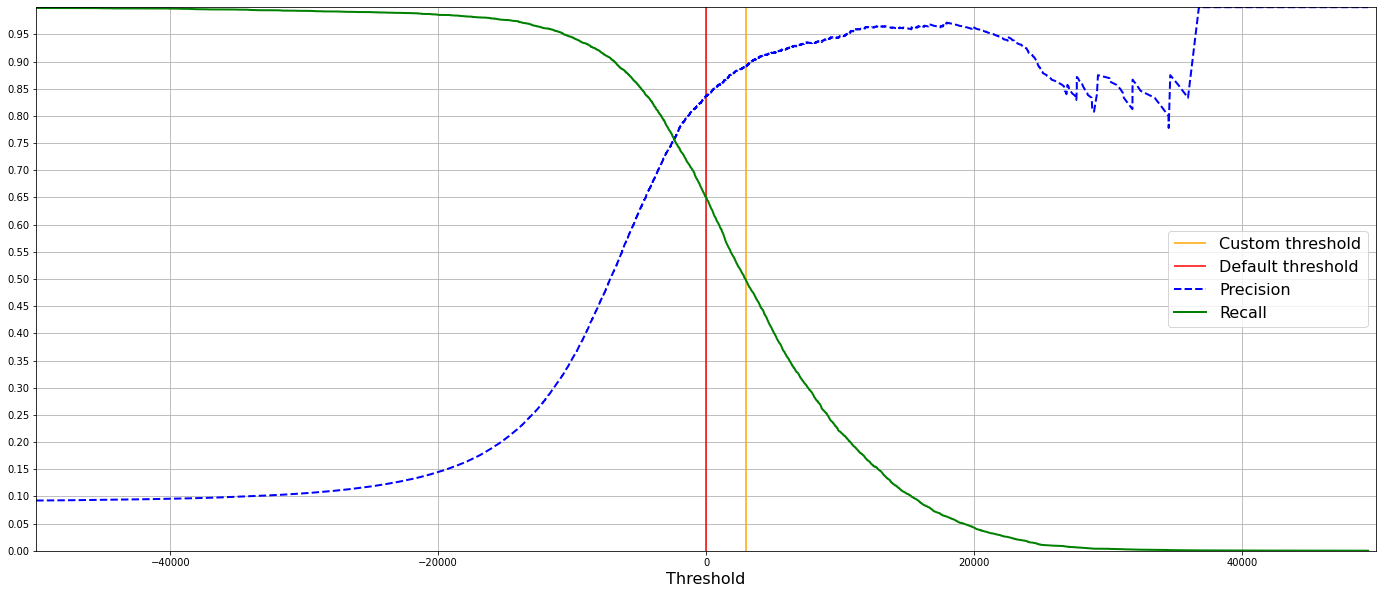

In [236]:
from sklearn.metrics import precision_recall_curve

# You can use sklearn precision_recall_curve() function to compute precision and recall for all possible thresholds. (Applies only to binary classifiers). This might be useful to you if you want to plot precision and recall vs the threshold, in case you want your model to have a specific ratio of precision or recall. With that plot you can see which threshold you need and then you can your self create a custom filter, which will return predictions based on that custom threshold vs decision scores.
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_decision_scores)

custom_threshold = 3000
default_threshold = 0


def plot_precision_recall_vs_threshold(precisions_, recalls_, thresholds_):
    plt.figure(figsize=(24, 10))
    plt.vlines(x=custom_threshold, ymin=0, ymax=1.0, colors="orange", linestyles="solid",
               label="Custom threshold")
    plt.vlines(x=default_threshold, ymin=0, ymax=1.0, colors="red", linestyles="solid",
               label="Default threshold")
    plt.plot(thresholds_, precisions_[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds_, recalls_[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.yticks(np.arange(0, 1, step=0.05))
    # plt.xticks(np.arange(-40_000, 40_000, step=5_000))
    plt.axis((-50000, 50000, 0, 1))


plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

# Take a look at the plot below. You see that at default threshold 0, which is used for predictions normally, precision is around 85% and recall around 65%, just as we evaluated it above. (You can check it few cells above)
# In case you wanted for example 90% precision, you can see that you would need to set the threshold to around 3000. But then you would have only around 50% recall. So you can see that there is a tradeoff between precision and recall.

In [237]:
# Just an example how decision scores are evaluated to default threshold of 0.
print(f"Thresholds:\n{thresholds}\n")
print(f"Decision scores:\n{y_decision_scores}\n")
for label, decision_score in zip(y_train[:5], y_decision_scores[:5]):
    print(f"Label: {label}, Prediction: {decision_score > 0}")



Thresholds:
[-146348.56726174 -142300.00705404 -137588.97581744 ...   38871.26391927
   42216.05562787   49441.43765905]

Decision scores:
[  1200.93051237 -26883.79202424 -33072.03475406 ...  13272.12718981
  -7258.47203373 -16877.50840447]

Label: 5, Prediction: True
Label: 0, Prediction: False
Label: 4, Prediction: False
Label: 1, Prediction: False
Label: 9, Prediction: False


In [238]:
# np.argmax - Returns index position of the highest value you specified in a filter
index_position_for_90_recall = np.argmax(precisions == 0.90)
recall_with_90_precision = recalls[index_position_for_90_recall]
threshold_90_precision = thresholds[index_position_for_90_recall]

# instead of calling default predict() method, we can use our filter with custom threshold which will now evaluate the array to boolean results to get our scoring to desired 90% precision
y_train_90_precision = y_decision_scores >= threshold_90_precision

print(f"Recall value with 90 precision: {recall_with_90_precision}")
print(f"Threshold value with 90 precision: {threshold_90_precision}")

Recall value with 90 precision: 0.47980077476480354
Threshold value with 90 precision: 3370.0692037709423


In [239]:
# results correspond to the plot above and also the one below
print(precision_score(y_train_5, y_train_90_precision))
print(recall_score(y_train_5, y_train_90_precision))

0.9
0.47980077476480354


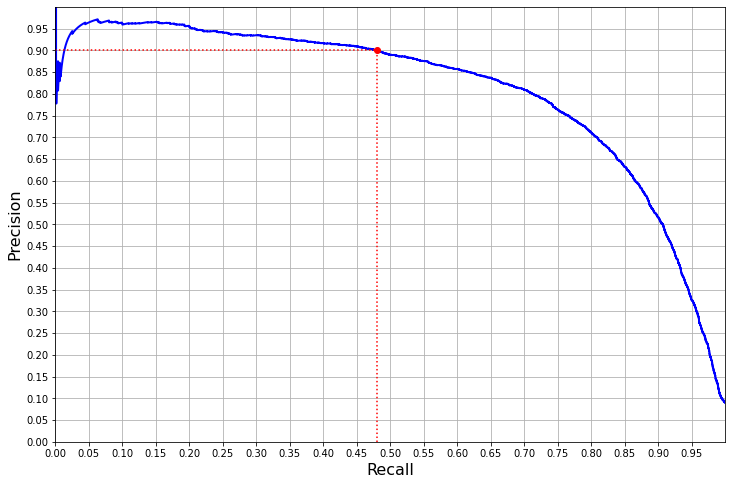

In [240]:
# Plot precision vs recall against each other

def plot_precision_vs_recall(precisions_, recalls_):
    plt.plot(recalls_, precisions_, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis((0, 1, 0, 1))
    plt.yticks(np.arange(0, 1, step=0.05))
    plt.xticks(np.arange(0, 1, step=0.05))
    plt.grid(True)


plt.figure(figsize=(12, 8))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_with_90_precision, recall_with_90_precision], [0., 0.9], "r:")  # vertical red line
plt.plot([0.0, recall_with_90_precision], [0.9, 0.9], "r:")  # horizontal red line
plt.plot([recall_with_90_precision], [0.9], "ro")  # red dot
plt.show()

# if I'm not wrong, this curve should be close to top right corner in ideal case

#### ROC CURVE (RECEIVER OPERATING CHARACTERISTICS)

In [241]:
# Another way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC.

# Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use:
#   - Use Precision/Recall curve whenever the positive class is rare 
#   - Use Precision/Recall when you care more about the false positives than the false negatives

# Use the ROC curve otherwise. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-right corner).

from sklearn.metrics import roc_auc_score

# See, the score is high, but it does not make sense to use this metrics, since we have only 10% of 5s in the dataset. Use Precision/Recall curve instead in this case.
print(f"ROC AUC score: {roc_auc_score(y_train_5, y_decision_scores)}")

ROC AUC score: 0.9604938554008616


False positive rate at 90% precision: 0.005295076861063779
Recall at 90% precision: 0.47980077476480354


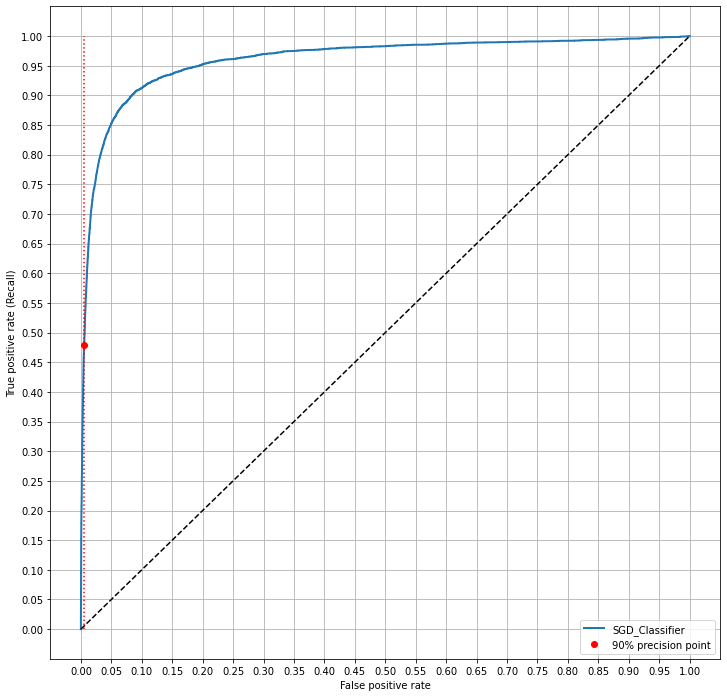

In [242]:
# The plot below shows the ROC curve. This ROC curve plots the false positive rate against the true positive rate (recall) for all possible thresholds, the red circle highlights the chosen ratio (at 47% recall) and the diagonal line is the ROC curve of purely random binary classifier which predicts 50% of each class. Recall is not visible at the graph below, but the ratio of precision and recall is kept the same, therefore the recall you see below still corresponds to  precision of 90%.
from sklearn.metrics import roc_curve

false_positive_rate, true_positive_rate, thresholds \
    = roc_curve(y_true=y_train_5, y_score=y_decision_scores)

# Get false positive rate at 90% precision, at 47% recall
false_positive_rate_90 = false_positive_rate[
    np.argmax(true_positive_rate >= recall_with_90_precision)]
print(f"False positive rate at 90% precision: {false_positive_rate_90}")
print(f"Recall at 90% precision: {recall_with_90_precision}")


def plot_roc_curve(fpr, tpr, label_=None):
    """
    :param fpr: false positive rate 
    :param tpr: true positive rate
    :return: 
    """
    plt.plot(fpr, tpr, linewidth=2, label=label_)
    plt.plot([false_positive_rate_90],
             [recall_with_90_precision],
             "ro",
             label="90% precision point")  # red dot
    plt.plot([0, 1], [0, 1], "k--")  # dashed diagonal
    plt.grid()
    plt.yticks(np.arange(0, 1.05, step=0.05))
    plt.xticks(np.arange(0, 1.05, step=0.05))
    plt.plot([false_positive_rate_90, false_positive_rate_90], [0, 1], "r:")  # vertical red line
    plt.ylabel("True positive rate (Recall)")
    plt.xlabel("False positive rate")


plt.figure(figsize=(12, 12))
plot_roc_curve(false_positive_rate, true_positive_rate, "SGD_Classifier")
plt.legend()
plt.show()

# At the plot below, you see that the lower the false positive rate the better for use.
# At the same time the higher the recall the better for us.
# Seems like the ROC plot shows us also that there is some trade-off between false positive rate and recall. The better the false positives, the worse the recall. 
# This means that ideally we want to be as close to the top left corner as possible.

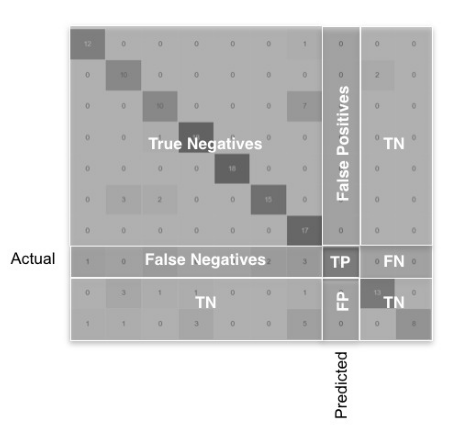

In [243]:
# Just a reminder of the confusion matrix glossary.
plt.figure(figsize=(8, 8))
image = plt.imread(r"..\performace_measurement\images\CONF_MATRIX3.jpg")
plt.axis("off")
plt.imshow(image)

y_train=array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)
y_scores_forest=array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])


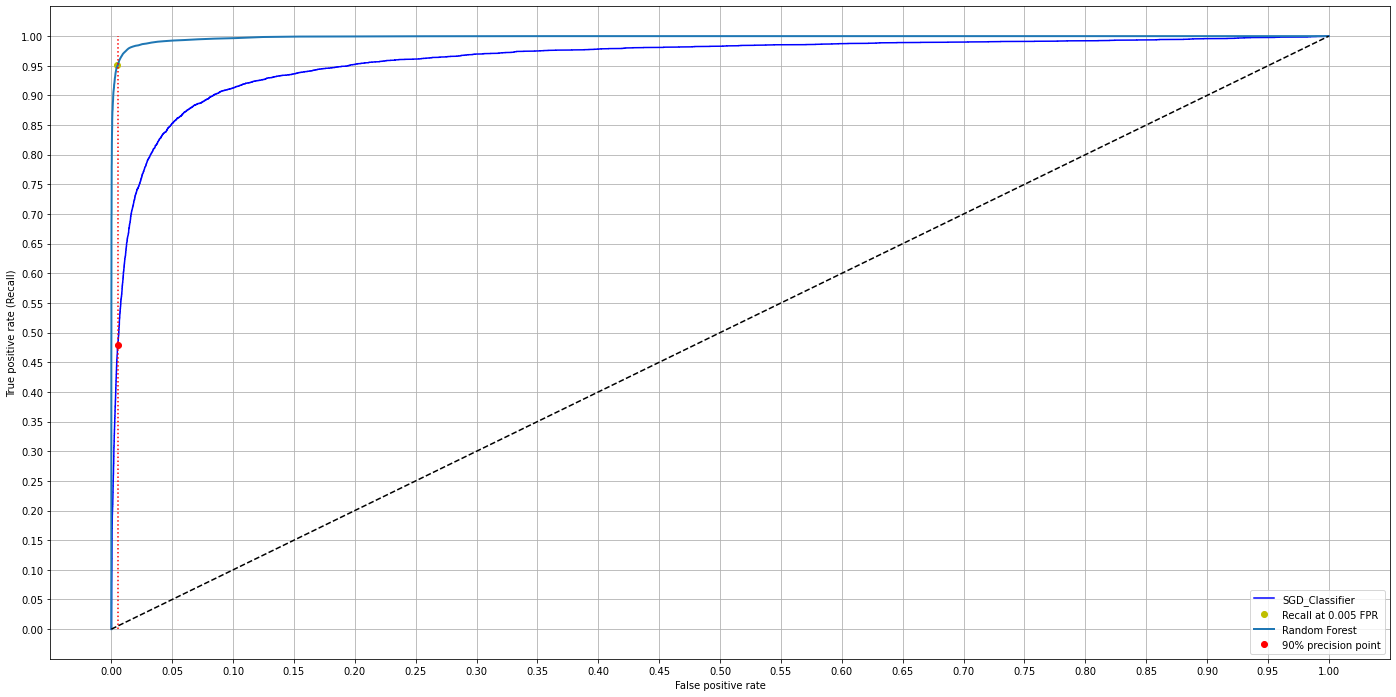

In [244]:
# Compare the roc curve of SGDClassifier vs RandomForestClassifier
# It takes 1 min to run this cell
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probabilities_forest = cross_val_predict(
    estimator=forest_clf,
    X=X_train,
    y=y_train_5,
    cv=3,
    method="predict_proba"
)

y_scores_forest = y_probabilities_forest[:, 1]  # score = probability of positive class
print(f"{y_train=}")
print(f"{y_scores_forest=}")

false_positive_rate_forest, true_positive_rate_forest, thresholds_forest \
    = roc_curve(y_true=y_train_5, y_score=y_scores_forest)

recall_for_forest = true_positive_rate_forest[np.argmax(false_positive_rate_forest >= 0.005)]

# figure is a little bit extended, so you can see the red line better
plt.figure(figsize=(24, 12))
plt.plot(false_positive_rate, true_positive_rate, "b", label="SGD_Classifier")
plt.plot([0.005], [recall_for_forest], "yo", label="Recall at 0.005 FPR")  # yellow dot
plot_roc_curve(false_positive_rate_forest, true_positive_rate_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

# Below you see that random forest is superior to SGD classifier because the curve of random forest is much closer to the top left corner compared to SGD classifier.
# For demonstration purposes, I keep the original red dot at the same place, and I extended the red line to the top. Now you see that with the new random forest classifier, we are much closer to the top left corner and we have about 95% recall at the same FPR as before.

# MULTICLASS CLASSIFICATION

In [245]:
# Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.

# Some algorithms (such as Logistic Regression classifiers, Random Forest classifiers, and naive Bayes classifiers) are capable of handling multiple classes natively. Others (such as SGD Classifiers or Support Vector Machine classifiers) are strictly binary classifiers. However, there are various strategies that you can use to perform multiclass classification using multiple binary classifiers.

# One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-the-rest (OvR) strategy (also called one-versus-all).

# Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

# Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary classification algorithms, however, OvR is preferred.

In [246]:
# Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm. Let’s try this with a Support Vector Machine classifier, using the sklearn.svm.SVC class:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)  # y_train not y_train_5
svm_clf.predict([some_digit])

# here it should correctly predict that the number is 5

array([5], dtype=uint8)

In [247]:
# you can check the cores for each number
# you can see that the 5th index is highest meaning number 5 was chosen as a result

# under the hood, the classifier used OvO strategy
some_digit_scores = svm_clf.decision_function([some_digit])
print(f"Scores from decision function:\n{some_digit_scores}")

# 5th position has the greatest value, therefore the resulting prediction is number 5
print(f"Prediction: {np.argmax(some_digit_scores)}")


Scores from decision function:
[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
Prediction: 5


In [248]:
# check classes - types of y labels
print(svm_clf.classes_)

# check the 5th class (here the index position and actual class is the same, but in practise it will usually not happen)
print(svm_clf.classes_[5])


[0 1 2 3 4 5 6 7 8 9]
5


In [249]:
# if you want to directly one-versus-one or one-versus-rest you can use imported classes below
# Note: cell takes 13 minutes to run
from sklearn.multiclass import (OneVsRestClassifier,  # Used below
                                OneVsOneClassifier)  # Just an example

# pass support vector classifier directly as a parameter. Note that you do not need to pass only binary classifier into OneVsOneClassifier.
ovr_SV_classifier = OneVsRestClassifier(SVC())

ovr_SV_classifier.fit(X_train, y_train)
ovr_SV_classifier.predict([some_digit])

array([5], dtype=uint8)

In [250]:
print(f"Estimators: {ovr_SV_classifier.estimators_}")
print(f"Number of estimators: {len(ovr_SV_classifier.estimators_)}")

# TODO: In case you are interested how the decision function works in OVR and OVO classifiers, check it out on the net.
# In OVR these 10 scores might be scores of each individual estimator, but in OVO those scores must be somehow combined to get the final prediction. (Needs to be verified)
print(f"Decision function:\n{ovr_SV_classifier.decision_function([some_digit])}")

Estimators: [SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC()]
Number of estimators: 10
Decision function:
[[-2.20788779 -2.52734154 -1.42209483 -0.89545795 -3.66438164  1.09884347
  -3.13930844 -2.05006487 -2.51601851 -3.39312853]]


In [251]:
# As you see above, you have available 10 estimators, one for each class, and you can use each of them to predict whether the number is that class or not.
print("Is the number 0?: ", ovr_SV_classifier.estimators_[0].predict([some_digit]))
print("Is the number 2?: ", ovr_SV_classifier.estimators_[2].predict([some_digit]))
print("Is the number 5?: ", ovr_SV_classifier.estimators_[5].predict([some_digit]))

Is the number 0?:  [0]
Is the number 2?:  [0]
Is the number 5?:  [1]


In [252]:
# check also how SGD classifier fares with multiclass classification
# Note: cell takes 2 minutes to run
ovr_SGD_classifier = OneVsRestClassifier(SGDClassifier())

ovr_SGD_classifier.fit(X_train, y_train)
ovr_SGD_classifier.predict([some_digit])

array([5], dtype=uint8)

In [253]:
print(f"Estimators:\n{ovr_SGD_classifier.estimators_}")
print(f"Number of estimators: {len(ovr_SGD_classifier.estimators_)}")
print(f"Decision function:\n{ovr_SGD_classifier.decision_function([some_digit])}")

Estimators:
[SGDClassifier(), SGDClassifier(), SGDClassifier(), SGDClassifier(), SGDClassifier(), SGDClassifier(), SGDClassifier(), SGDClassifier(), SGDClassifier(), SGDClassifier()]
Number of estimators: 10
Decision function:
[[-11551.56844023 -46834.16738702  -6588.66719984  -4687.22765596
  -22291.97516816   1869.72596273 -28988.43165848 -12596.26088772
   -7796.06082139 -12063.50598827]]


In [254]:
# Note: cell takes 2 minutes to run
# This will compute binary classifiers for each pair fo classes. In this case 45 classifiers.
ovo_SV_classifier = OneVsOneClassifier(SVC())

ovo_SV_classifier.fit(X_train, y_train)
ovo_SV_classifier.predict([some_digit])

array([5], dtype=uint8)

In [255]:
# See that now we have 45 estimators, one for each pair of classes
print(f"Estimators:\n{ovo_SV_classifier.estimators_}")
print(f"Number of estimators: {len(ovo_SV_classifier.estimators_)}")

# For scores of decision function explanation in OVR and OVO check similar cell above
print(f"Decision function:\n{ovo_SV_classifier.decision_function([some_digit])}")

Estimators:
(SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC(), SVC())
Number of estimators: 45
Decision function:
[[ 2.72420789  2.72909219  7.25265966  8.30764043 -0.31037527  9.31302684
   0.70957317  2.76678409  6.22757724  4.84005057]]


In [256]:
# evaluate sgd_clf using cross-validation
# Note: This cell takes 3 minutes to run

# here it returns 3 results representing model's accuracy. If you had random classifier it would return only 0.1 meaning 10%. We can improve the accuracy by scaling the features, in the cell below.
cross_val_score(ovr_SGD_classifier, X_train, y_train, cv=3, scoring="accuracy")

array([0.8628, 0.8811, 0.8774])

In [257]:
# scale our features with standard scaler and get better results out of cross-validation
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# TODO: It is strange to see that standardisation (StandardScaler) of feature values such as 0 results sometimes in 0 but sometimes not, even in the same array. Check the example in the printed values below. Also due to this strange result of standardisation, the cross-validation score predictions do not converge and it results in error. I therefore used MinMaxScaler instead and it produced results which make sense both in scaling and also in the final scoring.
scaler = MinMaxScaler() # Replace with StandardScaler() to see the strange behaviour
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))


feature_middle_indexes = [350, 400, 450, 500, 550] # Just random pick of some indexes
feature_first_indexes = [0, 1, 2, 3, 4, 5]
index_of_first_feature = 0

print(f"Before scaling beginning of picture: {X_train[index_of_first_feature, feature_first_indexes]}")
print(f"After scaling beginning of picture: {X_train_scaled[index_of_first_feature, feature_first_indexes]}")

print(sep.separator())

print(f"Before scaling middle of picture: {X_train[index_of_first_feature, feature_middle_indexes]}")
print(f"After scaling middle of picture: {X_train_scaled[index_of_first_feature, feature_middle_indexes]}")

print(sep.separator())


ovr_SGD_classifier = OneVsRestClassifier(SGDClassifier())
ovr_SGD_classifier.fit(X_train_scaled, y_train)

cross_val_score(ovr_SGD_classifier, X_train_scaled, y_train, cv=3, scoring='accuracy')

Before scaling beginning of picture: [0. 0. 0. 0. 0. 0.]
After scaling beginning of picture: [0. 0. 0. 0. 0. 0.]
[1] -------------------------------------------------------------------------------

Before scaling middle of picture: [ 70.   0.   0.   0. 250.]
After scaling middle of picture: [0.2745098  0.         0.         0.         0.98039216]
[2] -------------------------------------------------------------------------------


array([0.90305, 0.90735, 0.9101 ])

# ERROR ANALYSIS

In [297]:
# get array of predictions based on all features

y_train_predictions = cross_val_predict(
    estimator=ovr_SGD_classifier, 
    X=X_train_scaled,
    y=y_train,
    cv=3
)

# you can of course use just normal predict method, but cross_val_predict is better because it uses cross-validation and therefore it does not use the same data for training and testing (yes the data is used for both training and testing in the cross_val_predict method)
# y_train_pred_ = ovr_SGD_classifier.predict(X_train_scaled)
y_train_predictions

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [259]:
confusion_matrix = confusion_matrix(y_train, y_train_predictions)
confusion_matrix

array([[5774,    2,   13,    9,   10,   36,   39,    9,   26,    5],
       [   1, 6561,   35,   17,    8,   36,    8,   14,   51,   11],
       [  76,   79, 5213,  110,   72,   37,   89,   84,  174,   24],
       [  46,   30,  163, 5304,   15,  260,   31,   68,  116,   98],
       [  22,   25,   23,    4, 5385,   20,   52,   12,   40,  259],
       [  77,   25,   44,  122,   63, 4786,  121,   20,   96,   67],
       [  50,   19,   32,    4,   38,   88, 5657,    5,   21,    4],
       [  28,   21,   59,   20,   77,   19,    3, 5799,   21,  218],
       [  91,  144,   83,  155,   77,  256,   76,   25, 4813,  131],
       [  59,   22,   17,   86,  203,   89,    4,  170,   47, 5252]],
      dtype=int64)

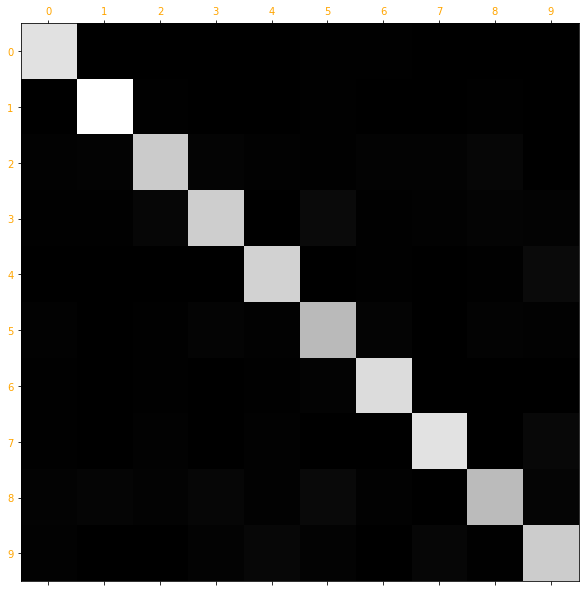

In [270]:
# To make matshow plot bigger, you must use figsize and fignum parameters
plt.figure(figsize=(10,10))
plt.matshow(confusion_matrix, cmap="gray", fignum=1)
plt.yticks(np.arange(0, 10, step=1), color="orange")
plt.xticks(np.arange(0, 10, step=1), color="orange")
plt.show()

# in the figure below you see that we have white diagonal, which is good. But there are also spots in the remaining parts of the plot which are not completely dark, and we should focus on them.
# just a reminder, rows in the confusion matrix represent actual classes, and columns represent predicted classes

In [261]:
# It would be better to check if we have even number of items in each class, because if we have uneven number of items in each class, then the confusion matrix will not be accurate in the form which we plotted above.

unique, counts = np.unique(y_train, return_counts=True)

classes_sorted = [x for _,x in sorted(zip(counts, unique))]
counts_sorted = counts[classes_sorted]
print(f"Classes: {classes_sorted}")
print(f"Counts: {counts_sorted}")

Classes: [5, 4, 8, 6, 0, 9, 2, 3, 7, 1]
Counts: [5421 5842 5851 5918 5923 5949 5958 6131 6265 6742]


Row sums:
[[5923]
 [6742]
 [5958]
 [6131]
 [5842]
 [5421]
 [5918]
 [6265]
 [5851]
 [5949]]

Normalised confusion matrix:
[[9.74843829e-01 3.37666723e-04 2.19483370e-03 1.51950025e-03
  1.68833361e-03 6.07800101e-03 6.58450110e-03 1.51950025e-03
  4.38966740e-03 8.44166807e-04]
 [1.48323939e-04 9.73153367e-01 5.19133788e-03 2.52150697e-03
  1.18659152e-03 5.33966182e-03 1.18659152e-03 2.07653515e-03
  7.56452091e-03 1.63156333e-03]
 [1.27559584e-02 1.32594830e-02 8.74958040e-01 1.84625713e-02
  1.20845921e-02 6.21013763e-03 1.49378986e-02 1.40986908e-02
  2.92044310e-02 4.02819738e-03]
 [7.50285435e-03 4.89316588e-03 2.65862013e-02 8.65111727e-01
  2.44658294e-03 4.24074376e-02 5.05627141e-03 1.10911760e-02
  1.89202414e-02 1.59843419e-02]
 [3.76583362e-03 4.27935638e-03 3.93700787e-03 6.84697022e-04
  9.21773365e-01 3.42348511e-03 8.90106128e-03 2.05409106e-03
  6.84697022e-03 4.43341321e-02]
 [1.42040214e-02 4.61169526e-03 8.11658366e-03 2.25050729e-02
  1.16214721e-02 8.82862940e-01 

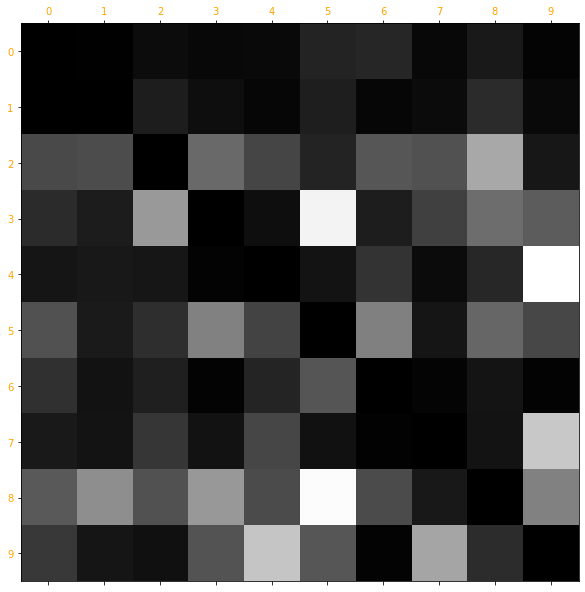

In [272]:
# correct the plot above to show not absolute numbers, but adjusted numbers based on the occurrence of each class 

# This makes the sum of each row (since all numbers in a given row in confusion matrix are total number of items in a given class)
row_sums = confusion_matrix.sum(axis=1, keepdims=True)
print(f"Row sums:\n{row_sums}\n")

# Divide each number at a given row by the sum of that row
normalised_confusion_matrix = confusion_matrix / row_sums
print(f"Normalised confusion matrix:\n{normalised_confusion_matrix}\n")

# fill diagonal with 0s to keep only the errors
np.fill_diagonal(normalised_confusion_matrix, 0)

plt.figure(figsize=(10,10))
plt.matshow(normalised_confusion_matrix, cmap="gray", fignum=1)
plt.yticks(np.arange(0, 10, step=1), color="orange")
plt.xticks(np.arange(0, 10, step=1), color="orange")
plt.show()

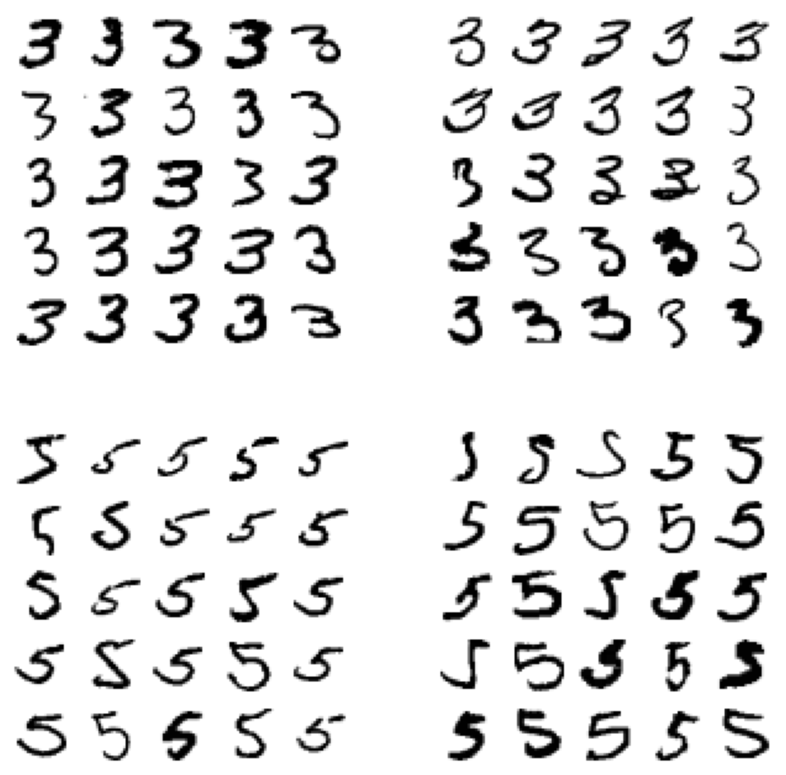

In [288]:
# This cell actually makes more sense on the results which are shown in the book. The author was trying to explain and visualise classification errors which were visible on his normalised confusion matrix plot. So to sum this up, my normalised confusion matrix is different compared to the book, but you can check the comparison of misclassified images below, which are very similar as in the book.

# filter out the data
class_3, class_5 = 3, 5
correct_predictions_3 = X_train[(y_train == class_3) & (y_train_predictions == class_3)]
classified_3_as_5 = X_train[(y_train == class_3) & (y_train_predictions == class_5)]
correct_predictions_5 = X_train[(y_train == class_5) & (y_train_predictions == class_5)]
classified_5_as_3 = X_train[(y_train == class_5) & (y_train_predictions == class_3)]

# create a figure with 4 subplots
plt.figure(figsize=(14, 14))

plt.subplot(221) # top left
plot_digits(correct_predictions_3[:25], images_per_row=5) 

plt.subplot(222) # top right
plot_digits(classified_3_as_5[:25], images_per_row=5)

plt.subplot(223) # bottom left
plot_digits(correct_predictions_5[:25], images_per_row=5)

plt.subplot(224) # bottom right
plot_digits(classified_5_as_3[:25], images_per_row=5)
plt.show()

# MULTILABEL CLASSIFICAITON
example - face recognition program. Program has been trained to reckognize Alice, Bob and Charlie. Now when we show it picture where are together Alice and Charlie it should output [1, 0, 1] (Yes, No, Yes)

In [291]:
# some not in depth example
from sklearn.neighbors import KNeighborsClassifier

# create new labels by making boolean for number bigger than 6 and another boolean for odd number. This means that what once used to be one label (number from 0 to 9) is now two labels [is_bigger_than_6, is_odd]
y_train_bigger_than_6 = y_train >= 7
y_train_odd = y_train % 2 == 1

# np.c_ made here y_train_large the first column, and y_train_odd second in the same array
y_multilabel = np.c_[y_train_bigger_than_6, y_train_odd]

print(y_multilabel)

[[False  True]
 [False False]
 [False False]
 ...
 [False  True]
 [False False]
 [ True False]]


In [304]:
k_nearest_neighbours_classifier = KNeighborsClassifier()
k_nearest_neighbours_classifier.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [305]:
# some_digit is 5, which is not bigger than 6 and it is odd
k_nearest_neighbours_classifier.predict([some_digit])

array([[False,  True]])

In [307]:
# example how to evalueate multilable classification (using F1 score)
y_train_knn_predictions = cross_val_predict(
    estimator=k_nearest_neighbours_classifier,
    X=X_train, 
    y=y_multilabel, 
    cv=3
)

# average='macro' means that you want to compute the average of the F1 score of each label, giving equal weight to each label. If you want to give each label a weight proportional to its support (some labels have more instances than others), you can set average='weighted' instead.
print(f"F1 score: {f1_score(
    y_true=y_multilabel, 
    y_pred=y_train_knn_predictions, 
    average='macro'
)}")

F1 score: 0.976410265560605


# MULTIOUTPUT CLASSIFICATION
In this example we will create a simple model capable of removing noise from artificially changed MNIST images.\
What does multioutput classification mean?\
On the example below, the prediction will have number of labels equal to number of pixels in the image. On top of that, each pixel will have a value from 0 to 255.

In [395]:
# create noise
noise = np.random.randint(low=0, high=150, size=(len(X_train), 784))
X_train_with_noise = X_train + noise

noise = np.random.randint(0, 150, (len(X_test), 784))
X_test_with_noise = X_test + noise

y_train = X_train
y_test = X_test

print(max(X_train_with_noise[0]))

# the lower the number of pixel, the lighter the pixel is. The higher the number of pixel, the darker the pixel is. 
# Note: If you are using the dark theme of IDE and color map that only works with black and white, the resulting plots might have inverted colors compared to the real image.
# You see that the max number is higher than 255, I think that matplotlib is doing some kind of normalization.

402.0


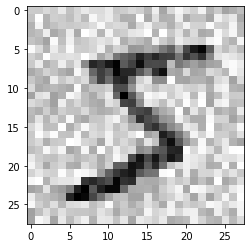

In [396]:
# with noise
plt.imshow(X_train_with_noise[0].reshape((28, 28)), cmap="binary")

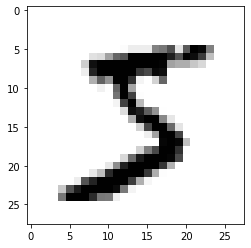

In [397]:
# original image which is now label to the one with noise
plt.imshow(y_train[0].reshape((28, 28)), cmap="binary")

array([199.,  97.,  35., 129., 159.,  41., 225.,  24., 127.,  53., 168.,
        87., 157., 241., 163.,  55., 207., 123., 230., 240., 253., 112.,
        50., 219., 206.,  52., 133.,  93.,  25.,  72.,  44., 193.,  11.,
        26., 193.,  87.,   4., 194.,  29.,  24.,  20.,   1.,  78., 132.,
         5., 140., 147., 246., 103., 234., 152., 235.,  79., 247., 117.,
        69.,  74., 231.,  36., 229., 139., 185., 199.,  32., 118.,  17.,
       245., 207., 123.,  93.,  64., 241.,  11., 223.,  55., 174., 129.,
        54., 147., 192., 203.,   1.,  73., 180., 193.,  25., 241., 117.,
        48., 113., 223.,  59.,  83., 251., 157.,   0., 134., 245., 100.,
       140., 165.,  81.,  36., 160.,   2., 136., 223.,  14., 203., 245.,
       132., 122., 183., 163.,  59.,  28., 133.,  67., 135., 105.,  30.,
        29., 236.,  29., 211.,  60.,  72., 139.,  85., 150.,  66., 227.,
        71.,  99.,  83.,  28., 142., 208., 208., 182.,  56., 158.,  54.,
        10., 164.,  38.,  82.,  99., 213., 233., 20

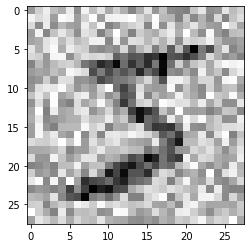

In [398]:
# In case you want to add some noise to the single image, it seems that you have to assign individual random value to each pixel, otherwise it will just offset the whole image and the ratios will stay the same, meaning the image will look the same. I am surprised that it worked on the complete dataset of all features on the high level, meaning as previously written: all_features + np.random.randint.
result = []
for pixel in y_train[0]:
    result += [pixel + np.random.randint(0, 255)]
result = np.array(result)
plt.imshow(result.reshape((28, 28)), cmap="binary")
result

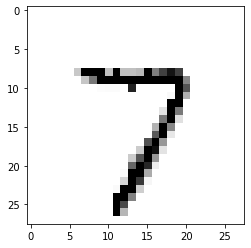

In [399]:
# predict
k_nearest_neighbours_classifier.fit(X_train_with_noise, y_train)
clean_digit = k_nearest_neighbours_classifier.predict([X_test_with_noise[0]])
plt.imshow(clean_digit.reshape((28, 28)), cmap="binary")

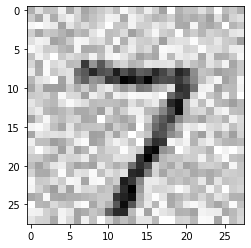

In [400]:
# former image
plt.imshow(X_test_with_noise[0].reshape((28, 28)), cmap="binary")